# Hecho por:


1.   Mateo Herran Murcia

2.   Miller Infante

1.   Jesus David Montes Correa



# Sistema de Detección de Anormalidades Térmicas en Imágenes

Este script de Python implementa un sistema para analizar imágenes térmicas, detectar posibles "puntos calientes" o anormalidades térmicas, y clasificarlas utilizando un modelo de Machine Learning (SVC). El sistema permite una interacción con el usuario para validar las predicciones del modelo y reentrenarlo con nueva información, mejorando así su precisión continuamente. Es una herramienta útil para el monitoreo de equipos eléctricos o motores, identificando áreas con sobrecalentamiento que podrían indicar una falla inminente.

## Importaciones y Configuración Global

Esta sección define las librerías necesarias para el funcionamiento del script y las variables de configuración globales que controlan rutas, tamaños de imágenes, nombres de categorías y más.

### Importaciones
Se importan las siguientes librerías de Python:
- `os`: Para interactuar con el sistema operativo, como la gestión de rutas de archivos.
- `cv2` (OpenCV): Para el procesamiento de imágenes (lectura, redimensionamiento, conversión de color, manipulación de contornos, etc.).
- `numpy`: Para operaciones numéricas eficientes, especialmente con arrays.
- `matplotlib.pyplot`: Para la visualización de imágenes y gráficos.
- `joblib`: Para serializar y deserializar modelos de Scikit-learn.
- `shutil`: Para operaciones de alto nivel con archivos y directorios, como copiar.
- `sklearn.svm.SVC`: La clase del clasificador Support Vector Machine.
- `sklearn.model_selection.train_test_split`: Para dividir los datos en conjuntos de entrenamiento y prueba.
- `sklearn.metrics.accuracy_score`, `classification_report`: Para evaluar el rendimiento del modelo.
- `collections.Counter`: Para contar la frecuencia de elementos en una lista (usado para la distribución de clases).
- `warnings`: Para controlar la emisión de advertencias (desactivadas en este script).




In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import joblib
import shutil
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

### Configuración Global
Estas variables definen parámetros clave utilizados en todo el script:
- `BASE_DIR`: Directorio base donde se almacenarán las imágenes del dataset.
- `MODEL_FILE`: Nombre del archivo donde se guardará el modelo de Machine Learning entrenado.
- `CATEGORIAS`: Lista de las categorías de clasificación (e.g., 'normal', 'falla'), que también se usan como nombres de carpetas.
- `IMG_SIZE`: Tamaño al que se redimensionarán las imágenes para ser procesadas por el modelo (cuadrado).
- `VISUAL_SIZE`: Tamaño de referencia para redimensionar imágenes para visualización, manteniendo la proporción.
- `DISPLAY_LABELS`: Un diccionario que mapea los nombres internos de las categorías a etiquetas más descriptivas para mostrar al usuario.

In [ ]:
# --- CONFIGURACIÓN GLOBAL ---
BASE_DIR = "dataset_electrico"
MODEL_FILE = "modelo_termico.pkl"
CATEGORIAS = ["normal", "falla"]
IMG_SIZE = 128
VISUAL_SIZE = 600

DISPLAY_LABELS = {
    "normal": "Normal",
    "falla": "Posible Falla por Anormalidad Térmica"
}

## Descarga y Preparación del Dataset (Opcional)

Esta sección describe la función `descargar_y_preparar_dataset()` que permite obtener el conjunto de datos de imágenes térmicas directamente desde KaggleHub si no está disponible localmente. Se encarga de descargar el archivo y organizar las imágenes en las carpetas `normal` y `falla` dentro del `BASE_DIR`.

In [ ]:
def descargar_y_preparar_dataset():
    try:
        import kagglehub
    except Exception:
        print("ADVERTENCIA: kagglehub no está instalado. Instálalo con: pip install kagglehub")
        return False

    print("\nDescargando dataset desde Kaggle (kagglehub)...")
    try:
        path = kagglehub.dataset_download("python16/electric-motor-thermal-image-fault-diagnosis")
    except Exception as e:
        print(f"ERROR: Error descargando dataset: {e}")
        return False

    print("Dataset descargado en:", path)

    images_dir = None
    for root, dirs, files in os.walk(path):
        if os.path.basename(root).lower() == "images":
            images_dir = root
            break

    if images_dir is None:
        print("ERROR: No se encontró la carpeta 'images' en el dataset descargado.")
        return False

    fault_src = os.path.join(images_dir, "fault")
    nofault_src = os.path.join(images_dir, "no_fault")

    if not os.path.exists(fault_src) or not os.path.exists(nofault_src):
        print("ERROR: No se encontraron las subcarpetas 'fault' o 'no_fault' dentro de images.")
        return False

    dest_fault = os.path.join(BASE_DIR, "falla")
    dest_nofault = os.path.join(BASE_DIR, "normal")
    os.makedirs(dest_fault, exist_ok=True)
    os.makedirs(dest_nofault, exist_ok=True)

    def copiar_imagenes(src, dst):
        for f in os.listdir(src):
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                srcf = os.path.join(src, f)
                dstf = os.path.join(dst, f)
                if not os.path.exists(dstf):
                    shutil.copy2(srcf, dstf)

    copiar_imagenes(fault_src, dest_fault)
    copiar_imagenes(nofault_src, dest_nofault)

    print("Dataset preparado en:", BASE_DIR)
    return True

- **Manejo de `kagglehub`**: Intenta importar la librería `kagglehub`. Si no está instalada, emite una advertencia. Esta librería es fundamental para interactuar con Kaggle.
- **Descarga del Dataset**: Utiliza `kagglehub.dataset_download()` para obtener el dataset especificado. Si la descarga falla, informa un error.
- **Localización de Imágenes**: Después de la descarga, el script busca la carpeta `images` dentro del dataset, que contiene las subcarpetas `fault` (falla) y `no_fault` (normal).
- **Creación de Directorios Destino**: Crea las carpetas `falla` y `normal` dentro del `BASE_DIR` definido globalmente. Estas carpetas son las que usará el modelo para clasificar.
- **Copia de Imágenes**: Define una función anidada `copiar_imagenes` para mover los archivos de imagen (`.png`, `.jpg`, `.jpeg`) desde las carpetas de origen del dataset descargado a las carpetas de destino organizadas localmente. Esto asegura que el dataset esté en el formato esperado por el script.

## Verificación y Carga de Datos

Antes de entrenar un modelo, es crucial verificar el estado y balance de los datos disponibles, y luego cargarlos en un formato que el modelo pueda procesar. Estas funciones se encargan de estos pasos.

### `verificar_balance_datos()`
Esta función inspecciona las carpetas `normal` y `falla` dentro del `BASE_DIR` para contar el número de imágenes en cada categoría. Esto ayuda a identificar posibles desequilibrios en el dataset, los cuales pueden afectar el rendimiento del modelo.


In [ ]:
def verificar_balance_datos():
    print("\n--- VERIFICANDO BALANCE DE DATOS ---")
    conteo_clases = {}
    for categoria in CATEGORIAS:
        path = os.path.join(BASE_DIR, categoria)
        if os.path.exists(path):
            archivos = [f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            conteo_clases[categoria] = len(archivos)
            print(f"   {DISPLAY_LABELS[categoria].upper()}: {len(archivos)} imágenes")
        else:
            conteo_clases[categoria] = 0
            print(f"   {DISPLAY_LABELS[categoria].upper()}: 0 imágenes")
    min_imagenes = min(conteo_clases.values())
    if min_imagenes < 2:
        print(f"\nADVERTENCIA: Clase con menos de 2 imágenes detectada")
        return False, conteo_clases
    return True, conteo_clases

- **Conteo de Imágenes**: Itera sobre las categorías definidas en `CATEGORIAS`, cuenta los archivos de imagen válidos (`.png`, `.jpg`, `.jpeg`) en cada carpeta y muestra el recuento.
- **Detección de Datos Insuficientes**: Emite una advertencia si alguna categoría tiene menos de 2 imágenes, lo cual es crítico para la división de datos en entrenamiento y prueba.

### `cargar_datos_entrenamiento()`
Esta función es responsable de leer las imágenes desde el disco, preprocesarlas (convertirlas a escala de grises, redimensionarlas y aplanarlas) y preparar los conjuntos de características (`X`) y etiquetas (`y`) para el entrenamiento del modelo.


In [ ]:
def cargar_datos_entrenamiento():
    data = []
    labels = []
    for categoria in CATEGORIAS:
        path = os.path.join(BASE_DIR, categoria)
        class_num = CATEGORIAS.index(categoria)
        if not os.path.exists(path):
            continue
        archivos = [f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        for archivo in archivos:
            try:
                ruta_completa = os.path.join(path, archivo)
                img = cv2.imread(ruta_completa)
                if img is not None:
                    if len(img.shape) == 3:
                        gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    else:
                        gris = img.copy()
                    gris_resized = cv2.resize(gris, (IMG_SIZE, IMG_SIZE))
                    caracteristicas = gris_resized.flatten()
                    data.append(caracteristicas)
                    labels.append(class_num)
            except Exception:
                continue
    return np.array(data), np.array(labels)

**Iteración por Categorías**: Recorre cada carpeta de categoría (`normal`, `falla`).
- **Lectura y Preprocesamiento**: Para cada imagen:
    - La carga usando `cv2.imread()`.
    - La convierte a escala de grises si es una imagen a color (`cv2.cvtColor`).
    - La redimensiona al `IMG_SIZE` configurado globalmente (`cv2.resize`).
    - La aplana (`flatten()`) en un vector unidimensional de píxeles, que ser\u00e1 la entrada de características para el modelo.
- **Preparación de Etiquetas**: Asigna una etiqueta numérica a cada imagen basada en su categoría (`CATEGORIAS.index(categoria)`).
- **Devolución de Datos**: Retorna dos arrays de NumPy: `data` (características de las imágenes) y `labels` (etiquetas de clase correspondientes).

**entrenar_modelo_simple():** Esta función entrena y evalúa el modelo de clasificación de imágenes térmicas.

Carga y Validación de Datos: Llama a cargar_datos_entrenamiento() para obtener las características (X) y etiquetas (y). Verifica que haya un mínimo de 4 imágenes para asegurar que la división entre entrenamiento y prueba sea posible.


In [ ]:
def entrenar_modelo_simple():
    print("\n--- ENTRENANDO MODELO ---")
    X, y = cargar_datos_entrenamiento()
    if len(X) < 4:
        print(f"ERROR: Insuficientes datos ({len(X)} imágenes). Mínimo 4 requeridas para entrenar y evaluar.")
        return None, None
    print(f"Total de imágenes para entrenamiento: {len(X)}")
    print(f"Distribución de clases: {Counter(y)}")

    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y if len(np.unique(y))>1 else None
        )
    except Exception:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    modelo = SVC(kernel='linear', probability=True)
    modelo.fit(X_train, y_train)

    y_pred = modelo.predict(X_test)
    precision = accuracy_score(y_test, y_pred)
    print(f"Precisión en test: {precision:.2%}")
    print("Reporte de clasificación:")
    target_names_display = [DISPLAY_LABELS[c] for c in CATEGORIAS]
    print(classification_report(y_test, y_pred, target_names=target_names_display))

    joblib.dump(modelo, MODEL_FILE)
    print(f"Modelo guardado en {MODEL_FILE}")
    return modelo, precision


**División de Datos:** El conjunto total se divide en 80% para entrenamiento (X_train) y 20% para prueba (X_test) usando train_test_split. Se utiliza stratify para mantener el balance de clases en ambas particiones.

**Modelo SVC:** Inicializa y entrena el clasificador SVC (Support Vector Classification) con un kernel lineal, activando la opción probability=True para que pueda generar una confianza porcentual en sus predicciones.

**Evaluación:** Realiza predicciones (y_pred) sobre el conjunto de prueba y calcula la precisión (accuracy_score). Imprime un reporte de clasificación detallado.

**Persistencia:** El modelo entrenado se guarda (joblib.dump) en el archivo modelo_termico.pkl para su uso posterior sin necesidad de reentrenar.

**Retorno:** Devuelve el modelo entrenado y la precisión obtenida.

# **La función ejecuta los siguientes pasos clave:**

**Carga y Preparación:** Lee la imagen desde disco y crea dos versiones redimensionadas: una para visualización y otra para extraer características para el modelo ML.


P**reprocesamiento:**



* Convierte la imagen a escala de grises.
* Elimina texto, números y fondo para aislar el equipo principal usando operaciones morfológicas.



**Detección de Anomalías Térmicas:**


* Identifica zonas de alta temperatura basándose en percentiles de intensidad.
* Filtra regiones por área mínima para eliminar falsos positivos.


**Generación de Visualizaciones:**


* Crea un mapa de calor con paleta de colores JET para interpretación visual.
* Superpone marcadores verdes sobre las zonas calientes detectadas.


* Muestra cuatro vistas simultáneas: original, filtrada, mapa de calor y zonas marcadas.






**Extracción de Información:**


* Calcula centroides y áreas de cada zona caliente.

* Extrae características vectorizadas para el modelo ML.

* Proporciona datos cuantitativos en consola.


**Retorno de Resultados:**


* Devuelve características para clasificación, visualizaciones, conteo de zonas e información detallada.

* Esta función centraliza todo el análisis térmico, proporcionando tanto resultados visuales para el usuario como datos estructurados para el modelo de Machine Learning

In [ ]:
def eliminar_texto_y_numeros(imagen_gris):
    kernel_medio = np.ones((5, 5), np.uint8)
    kernel_grande = np.ones((10, 10), np.uint8)
    img_sin_texto = cv2.morphologyEx(imagen_gris, cv2.MORPH_OPEN, kernel_medio)
    img_sin_texto = cv2.morphologyEx(img_sin_texto, cv2.MORPH_CLOSE, kernel_grande)

    _, thresh = cv2.threshold(img_sin_texto, 50, 255, cv2.THRESH_BINARY)
    contornos, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mascara_equipos = np.zeros_like(imagen_gris)

    for cnt in contornos:
        area = cv2.contourArea(cnt)
        if area > 1000:
            cv2.drawContours(mascara_equipos, [cnt], -1, 255, -1)

    img_filtrada = cv2.bitwise_and(imagen_gris, imagen_gris, mask=mascara_equipos)
    return img_filtrada, mascara_equipos

def crear_mapa_calor(imagen_gris):
    img_normalized = cv2.normalize(imagen_gris, None, 0, 255, cv2.NORM_MINMAX)
    mapa_calor = cv2.applyColorMap(img_normalized, cv2.COLORMAP_JET)
    return mapa_calor

def detectar_regiones_calientes(imagen_gris, mascara_equipos, percentile=90, min_area=500):
    img_norm = cv2.normalize(imagen_gris, None, 0, 255, cv2.NORM_MINMAX)
    valores = img_norm[mascara_equipos > 0]

    if valores.size == 0:
        return [], np.zeros_like(imagen_gris, dtype=np.uint8)

    umbral = np.percentile(valores, percentile)
    _, mask_hot = cv2.threshold(img_norm, int(umbral), 255, cv2.THRESH_BINARY)
    mask_hot = cv2.bitwise_and(mask_hot, mask_hot, mask=mascara_equipos)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    mask_hot = cv2.morphologyEx(mask_hot, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask_hot = cv2.morphologyEx(mask_hot, cv2.MORPH_OPEN, kernel, iterations=1)

    contornos, _ = cv2.findContours(mask_hot, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    regiones = []
    mask_final = np.zeros_like(imagen_gris, dtype=np.uint8)

    for cnt in contornos:
        area = cv2.contourArea(cnt)
        if area >= min_area:
            regiones.append({'contorno': cnt, 'area': area})
            cv2.drawContours(mask_final, [cnt], -1, 255, -1)

    regiones = sorted(regiones, key=lambda x: x['area'], reverse=True)
    return regiones, mask_final

def overlay_verde_sobre_imagen(imagen_bgr, mask_zonas, alpha=0.5):
    overlay = imagen_bgr.copy()
    verde = np.zeros_like(imagen_bgr, dtype=np.uint8)
    verde[:] = (0, 255, 0)

    mask_bool = mask_zonas > 0
    blended = cv2.addWeighted(imagen_bgr, 1-alpha, verde, alpha, 0)
    overlay[mask_bool] = blended[mask_bool]

    return overlay

**Procesado Principal y Visualización La función procesar_imagen_termica():** es el núcleo del análisis de imágenes térmicas. Coordina la carga de la imagen, su preprocesamiento, la detección de zonas de alta temperatura y la generación de visualizaciones para el usuario. Esta función integra todo el flujo de procesamiento desde la imagen original hasta la identificación de posibles anomalías térmicas.

procesar_imagen_termica(ruta_img, percentile=90, min_area=500)

In [ ]:
def procesar_imagen_termica(ruta_img, percentile=90, min_area=500):
    # Cargar la imagen
    img = cv2.imread(ruta_img)
    if img is None:
        print(f"ERROR: No se pudo cargar la imagen: {ruta_img}")
        return None, None, None, 0, []

    # Obtener dimensiones originales
    h, w = img.shape[:2]

    # Redimensionar para visualización (manteniendo proporción)
    scale_vis = VISUAL_SIZE / max(h, w)
    vis_h, vis_w = int(h * scale_vis), int(w * scale_vis)
    img_visual = cv2.resize(img, (vis_w, vis_h))

    # Convertir a escala de grises para procesamiento
    if len(img_visual.shape) == 3:
        img_gris = cv2.cvtColor(img_visual, cv2.COLOR_BGR2GRAY)
    else:
        img_gris = img_visual.copy()

    # Redimensionar para el modelo ML (tamaño fijo)
    scale_model = IMG_SIZE / max(h, w)
    model_h, model_w = int(h * scale_model), int(w * scale_model)
    img_model = cv2.resize(img, (model_w, model_h))
    if len(img_model.shape) == 3:
        gray_model = cv2.cvtColor(img_model, cv2.COLOR_BGR2GRAY)
    else:
        gray_model = img_model.copy()
    caracteristicas = gray_model.flatten()

    # Eliminar texto/números y obtener máscara del equipo
    img_filtrada, mascara_equipos = eliminar_texto_y_numeros(img_gris)

    # Detectar regiones de alta temperatura
    regiones, mask_hot = detectar_regiones_calientes(img_filtrada, mascara_equipos,
                                                     percentile=percentile, min_area=min_area)

    # Crear mapa de calor visual
    mapa_calor_filtrado = crear_mapa_calor(img_filtrada)

    # Ajustar tamaño de máscara si es necesario
    if mask_hot.shape != mapa_calor_filtrado.shape[:2]:
        mask_hot_resized = cv2.resize(mask_hot, (mapa_calor_filtrado.shape[1],
                                                 mapa_calor_filtrado.shape[0]),
                                       interpolation=cv2.INTER_NEAREST)
    else:
        mask_hot_resized = mask_hot

    # Aplicar superposición verde sobre zonas calientes
    mapa_con_overlay = overlay_verde_sobre_imagen(mapa_calor_filtrado, mask_hot_resized, alpha=0.45)

    # Dibujar contornos verdes sobre imagen original
    img_borde = img_visual.copy()
    for r in regiones:
        cv2.drawContours(img_borde, [r['contorno']], -1, (0,255,0), 3)

    # Mostrar visualizaciones (4 ventanas)
    plt.figure(figsize=(12, 8))
    plt.subplot(2,2,1); plt.imshow(cv2.cvtColor(img_visual, cv2.COLOR_BGR2RGB))
    plt.title("IMAGEN ORIGINAL"); plt.axis('off')

    plt.subplot(2,2,2); plt.imshow(img_filtrada, cmap='gray')
    plt.title("IMAGEN FILTRADA"); plt.axis('off')

    plt.subplot(2,2,3); plt.imshow(cv2.cvtColor(mapa_calor_filtrado, cv2.COLOR_BGR2RGB))
    plt.title("MAPA DE CALOR"); plt.axis('off')

    plt.subplot(2,2,4); plt.imshow(cv2.cvtColor(img_borde, cv2.COLOR_BGR2RGB))
    plt.title(f"ZONAS CALIENTES - {len(regiones)} regiones"); plt.axis('off')

    plt.tight_layout()
    plt.show(block=False)
    plt.pause(2)

    # Calcular información de las regiones detectadas
    puntos_info = []
    for i, r in enumerate(regiones):
        M = cv2.moments(r['contorno'])
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
        else:
            cx, cy = 0, 0
        puntos_info.append({'centro': (cx, cy), 'area': r['area']})

    # Mostrar información en consola
    if regiones:
        print(f"\nINFORMACIÓN TÉRMICA:")
        print(f"  Regiones calientes detectadas: {len(regiones)}")
        for i, info in enumerate(puntos_info[:5]):
            print(f"  - Región {i+1}: centro={info['centro']}, área={int(info['area'])} px")

    return caracteristicas, img_visual, mapa_con_overlay, len(regiones), puntos_info

## Guardado de Imagen Según Evaluación del Usuario

Esta sección describe la función `guardar_imagen_con_analisis()`, que se encarga de almacenar la imagen analizada por el usuario, marcando las zonas calientes con un color (verde para normal, rojo para falla) y registrando la clasificación manual. Esto es crucial para la realimentación del modelo y su mejora continua.

 `guardar_imagen_con_analisis(img_para_guardar, puntos_info, clasificacion_real, ruta_original, num_zonas)`

In [ ]:
def guardar_imagen_con_analisis(img_para_guardar, puntos_info, clasificacion_real, ruta_original, num_zonas):
    img_guardar = img_para_guardar.copy()
    for i, info in enumerate(puntos_info):
        cx, cy = info['centro']
        color = (0,255,0) if clasificacion_real == 'normal' else (0,0,255) # Verde si normal, Rojo si falla
        cv2.circle(img_guardar, (cx, cy), 20, color, 3)
        cv2.putText(img_guardar, f"{i+1}", (cx-10, cy-25),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    nombre_archivo = os.path.basename(ruta_original)
    nombre_base, ext = os.path.splitext(nombre_archivo)
    nuevo_nombre = f"user_{nombre_base}_zones{num_zonas}{ext}"
    # Se usa 'normal'/'falla' para el nombre de la carpeta (consistencia interna)
    destino = os.path.join(BASE_DIR, clasificacion_real, nuevo_nombre)
    cv2.imwrite(destino, img_guardar)
    return destino, ("VERDE" if clasificacion_real == 'normal' else "ROJO")

- **Copia de la Imagen**: Se crea una copia de `img_para_guardar` (que es el mapa de calor con overlay de zonas calientes) para evitar modificar la original.
- **Marcado de Zonas Calientes**: Itera sobre la información de los puntos calientes (`puntos_info`). Para cada punto:
    - Dibuja un círculo alrededor del centro (`cv2.circle`).
    - Agrega un número identificador (`cv2.putText`).
    - El color del círculo y el texto será verde si la `clasificacion_real` es 'normal' y rojo si es 'falla'. Esto proporciona una retroalimentación visual inmediata sobre la clasificación del usuario.
- **Generación de Nombre de Archivo**: Se crea un nuevo nombre de archivo que incluye el prefijo `user_`, el nombre base original, el número de zonas detectadas y la extensión original. Esto ayuda a identificar las imágenes guardadas por el usuario y sus características.
- **Guardado en Directorio Correcto**: La imagen se guarda en la subcarpeta `normal` o `falla` dentro del `BASE_DIR`, según la `clasificacion_real` proporcionada por el usuario. Esto realimenta el dataset de entrenamiento con datos validados.
- **Retorno**: Devuelve la ruta completa donde se guardó la imagen y el color ('VERDE' o 'ROJO') utilizado para marcarla, lo cual puede ser útil para confirmación en la consola.

In [ ]:
def obtener_opinion_modelo(modelo, ruta_imagen):
    if modelo is None:
        return None, None
    try:
        img = cv2.imread(ruta_imagen)
        if img is None:
            return None, None
        # Proceso de pre-procesamiento idéntico al de entrenamiento
        if len(img.shape) == 3:
            gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gris = img.copy()
        gris_resized = cv2.resize(gris, (IMG_SIZE, IMG_SIZE))
        feat = gris_resized.flatten().reshape(1, -1)
        if hasattr(modelo, "predict_proba"):
            probs = modelo.predict_proba(feat)[0]
            pred = int(np.argmax(probs))
            return pred, probs
        else:
            pred = int(modelo.predict(feat)[0])
            probs = np.zeros(len(CATEGORIAS))
            probs[pred] = 1.0
            return pred, probs
    except Exception:
        return None, None

## Opinión del Modelo y Flujo Interactivo

Estas funciones gestionan la interacción del modelo con el usuario, permitiendo que el sistema obtenga una opinión inicial del modelo y luego reciba retroalimentación del usuario para validar o corregir la clasificación, lo que a su vez puede conducir a un reentrenamiento del modelo para mejorar su rendimiento.

 `obtener_opinion_modelo(modelo, ruta_imagen)`
Esta función utiliza el modelo entrenado para predecir la clase (normal o falla) de una imagen dada y, si el modelo lo permite, proporciona las probabilidades de cada clase. Es el primer paso para la interacción con el usuario, ofreciendo una predicción inicial.

- **Validación del Modelo**: Comprueba si un modelo ha sido cargado. Si no, no puede hacer predicciones.
- **Preprocesamiento Consistente**: Realiza el mismo preprocesamiento de imagen (escala de grises, redimensionamiento, aplanamiento) que se usó durante el entrenamiento del modelo para asegurar la compatibilidad de las características.
- **Predicción y Probabilidades**: Si el modelo tiene el método `predict_proba` (como SVC con `probability=True`), obtiene las probabilidades para cada clase. De lo contrario, solo obtiene la predicción de la clase.

### `analizar_imagen_interactivo(modelo)`
Esta es la función principal para la interacción con el usuario. Solicita una ruta de imagen, procesa la imagen para detectar zonas calientes, obtiene la opinión del modelo, pide al usuario que confirme la clasificación real, guarda la imagen con el análisis visual y, finalmente, reentrena el modelo con la nueva información si hay suficientes datos.

In [ ]:
def analizar_imagen_interactivo(modelo):
    print("\nANALIZADOR DE IMÁGENES TÉRMICAS ")
    ruta = input("Ruta de la imagen térmica: ").strip().replace('"', '').replace("'", "")
    if not os.path.exists(ruta):
        print("ERROR: El archivo no existe.")
        return modelo
    try:
        caracteristicas, img_visual, mapa_con_overlay, num_zonas, puntos_info = procesar_imagen_termica(ruta)
        plt.close('all')

        # Opinión previa del modelo
        pred, probs = obtener_opinion_modelo(modelo, ruta)
        if pred is not None and probs is not None:
            pred_label = CATEGORIAS[pred]
            confianza_pred = probs[pred]
            print("\nOPINIÓN DEL MODELO:")
            print(f"   - Predicción: {DISPLAY_LABELS[pred_label].upper()}")
            print(f"   - Confianza: {confianza_pred:.2%} (según datos actuales del modelo)")
        else:
            print("\nOPINIÓN DEL MODELO: No disponible (modelo no entrenado o no soporta probabilidades).")

        # Validación por el usuario
        print("\nPor favor confirma la etiqueta real de la imagen:")
        print("1. Normal (no posibles fallos o anormalidades térmicas)")
        print(f"2. {DISPLAY_LABELS['falla']} (puntos calientes, sobrecalentamiento, etc.)")
        print("3. Cancelar (no guardar ni reentrenar)")
        while True:
            opcion = input("Selecciona 1 (Normal), 2 (Posible Falla) o 3 (Cancelar): ").strip()
            if opcion == '1':
                clasificacion_real = 'normal'
                break
            elif opcion == '2':
                clasificacion_real = 'falla'
                break
            elif opcion == '3':
                print("Operación cancelada. No se guardó ni reentrenó.")
                return modelo
            else:
                print("Opción inválida. Usa 1, 2 o 3.")

        # Guardar la imagen con overlay verde (MAPA DE CALOR con overlay) según la validación del usuario
        destino, color_usado = guardar_imagen_con_analisis(mapa_con_overlay, puntos_info, clasificacion_real, ruta, num_zonas)
        print(f"Imagen guardada en: {destino} (color: {color_usado})")

        # Re-entrenar modelo con la nueva información
        print("Re-entrenando modelo con la nueva imagen (si hay datos suficientes)...")
        nuevo_modelo, precision = entrenar_modelo_simple()

        if nuevo_modelo is not None:
            modelo = nuevo_modelo
            try:
                pred_nuevo, probs_nuevo = obtener_opinion_modelo(modelo, destino)
                if pred_nuevo is not None and probs_nuevo is not None:
                    pred_nuevo_label = CATEGORIAS[pred_nuevo]
                    print("\nResultado del modelo tras reentrenar para la imagen guardada:")
                    print(f"   - Predicción: {DISPLAY_LABELS[pred_nuevo_label].upper()}")
                    print(f"   - Confianzas: {DISPLAY_LABELS[CATEGORIAS[0]]}={probs_nuevo[0]:.2%}, {DISPLAY_LABELS[CATEGORIAS[1]]}={probs_nuevo[1]:.2%}")
                else:
                    print("ADVERTENCIA: El modelo no pudo calcular probabilidades tras el reentrenamiento.")
            except Exception as e:
                print(f"ADVERTENCIA: No se pudo calcular la probabilidad tras reentrenar: {e}")

            if precision is not None:
                print(f"   - Precisión estimada actual (según partición test usada): {precision:.2%}")
        else:
            print("ADVERTENCIA: No se pudo reentrenar el modelo (datos insuficientes).")

        return modelo

    except Exception as e:
        print(f"ERROR: Error procesando imagen: {e}")
        plt.close('all')
        return modelo

- **Solicitud de Ruta**: Pide al usuario la ruta de la imagen a analizar.
- **Procesamiento de Imagen**: Llama a `procesar_imagen_termica()` para realizar el análisis visual y de zonas calientes, mostrando las visualizaciones.
- **Predicción del Modelo**: Invoca a `obtener_opinion_modelo()` para obtener la predicción y confianza actuales del modelo sobre la imagen.
- **Validación del Usuario**: Presenta un menú al usuario para que clasifique manualmente la imagen como 'Normal' o 'Posible Falla', o para cancelar la operación.
- **Guardado de Imagen Validada**: Si el usuario confirma, llama a `guardar_imagen_con_analisis()` para guardar la imagen con el overlay visual correspondiente a la clasificación confirmada, colocándola en el directorio de `BASE_DIR` adecuado (`normal` o `falla`).
- **Reentrenamiento del Modelo**: Finalmente, intenta reentrenar el modelo llamando a `entrenar_modelo_simple()`. Esto incorpora la imagen recién validada al conjunto de entrenamiento, mejorando el modelo con retroalimentación humana.
- **Actualización y Retorno**: El modelo actualizado se carga y se verifica su nueva predicción para la imagen recién guardada, mostrando la precisión y las nuevas confianzas. La función devuelve el modelo (actualizado o el original si no se reentrenó).

¿Deseas descargar y preparar el dataset desde Kaggle (kagglehub)?
s/n: s

Descargando dataset desde Kaggle (kagglehub)...
Using Colab cache for faster access to the 'electric-motor-thermal-image-fault-diagnosis' dataset.
Dataset descargado en: /kaggle/input/electric-motor-thermal-image-fault-diagnosis
Dataset preparado en: dataset_electrico

--- VERIFICANDO BALANCE DE DATOS ---
   NORMAL: 196 imágenes
   POSIBLE FALLA POR ANORMALIDAD TÉRMICA: 174 imágenes
Modelo cargado correctamente

SISTEMA DE ANÁLISIS TÉRMICO
   - El MAPA DE CALOR se mostrará; las zonas calientes se indican en VERDE en la vista separada
   - El modelo dará su opinión (Normal/Posible Falla por Anormalidad Térmica) con porcentaje, luego el usuario confirma
   - La imagen guardada será el MAPA DE CALOR con overlay verde (si confirmas)

ANALIZADOR DE IMÁGENES TÉRMICAS 
Ruta de la imagen térmica: /content/Imagen_2.2.jpeg


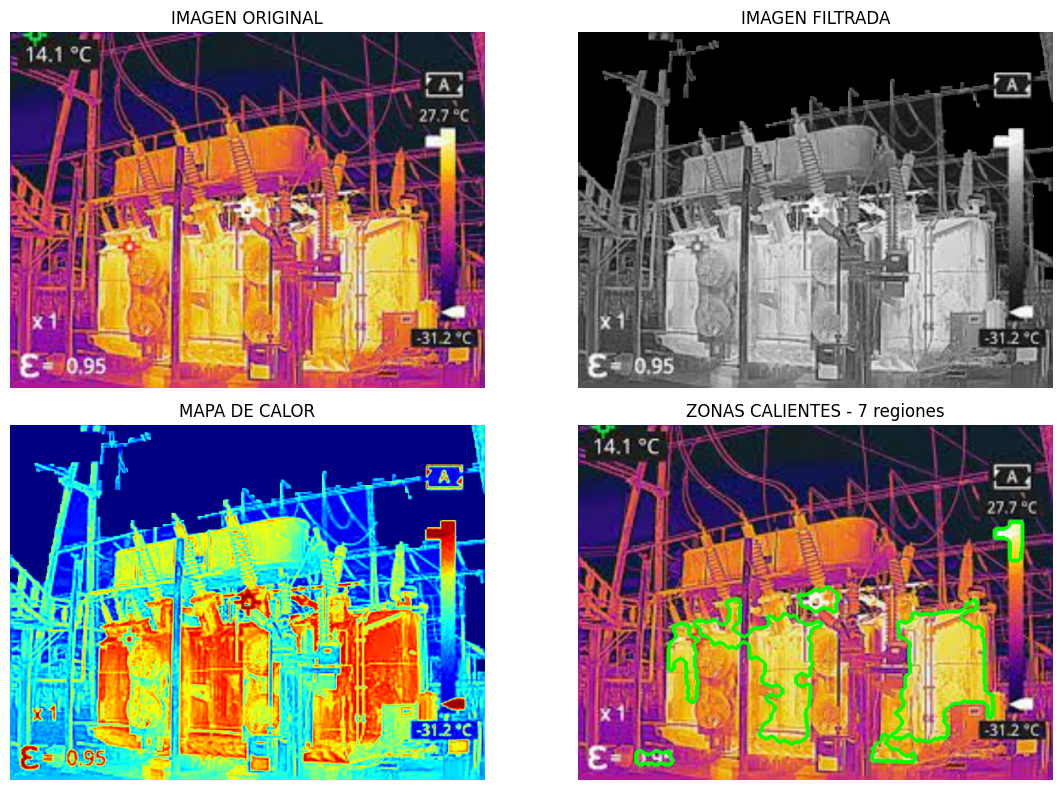


INFORMACIÓN TÉRMICA:
  Regiones calientes detectadas: 7
  - Región 1: centro=(457, 312), área=13902 px
  - Región 2: centro=(248, 305), área=10567 px
  - Región 3: centro=(134, 293), área=1933 px
  - Región 4: centro=(305, 221), área=1052 px
  - Región 5: centro=(548, 144), área=974 px

OPINIÓN DEL MODELO:
   - Predicción: POSIBLE FALLA POR ANORMALIDAD TÉRMICA
   - Confianza: 100.00% (según datos actuales del modelo)

Por favor confirma la etiqueta real de la imagen:
1. Normal (no posibles fallos o anormalidades térmicas)
2. Posible Falla por Anormalidad Térmica (puntos calientes, sobrecalentamiento, etc.)
3. Cancelar (no guardar ni reentrenar)
Selecciona 1 (Normal), 2 (Posible Falla) o 3 (Cancelar): 2
Imagen guardada en: dataset_electrico/falla/user_Imagen_2.2_zones7.jpeg (color: ROJO)
Re-entrenando modelo con la nueva imagen (si hay datos suficientes)...

--- ENTRENANDO MODELO ---
Total de imágenes para entrenamiento: 370
Distribución de clases: Counter({np.int64(0): 196, np.int64(1

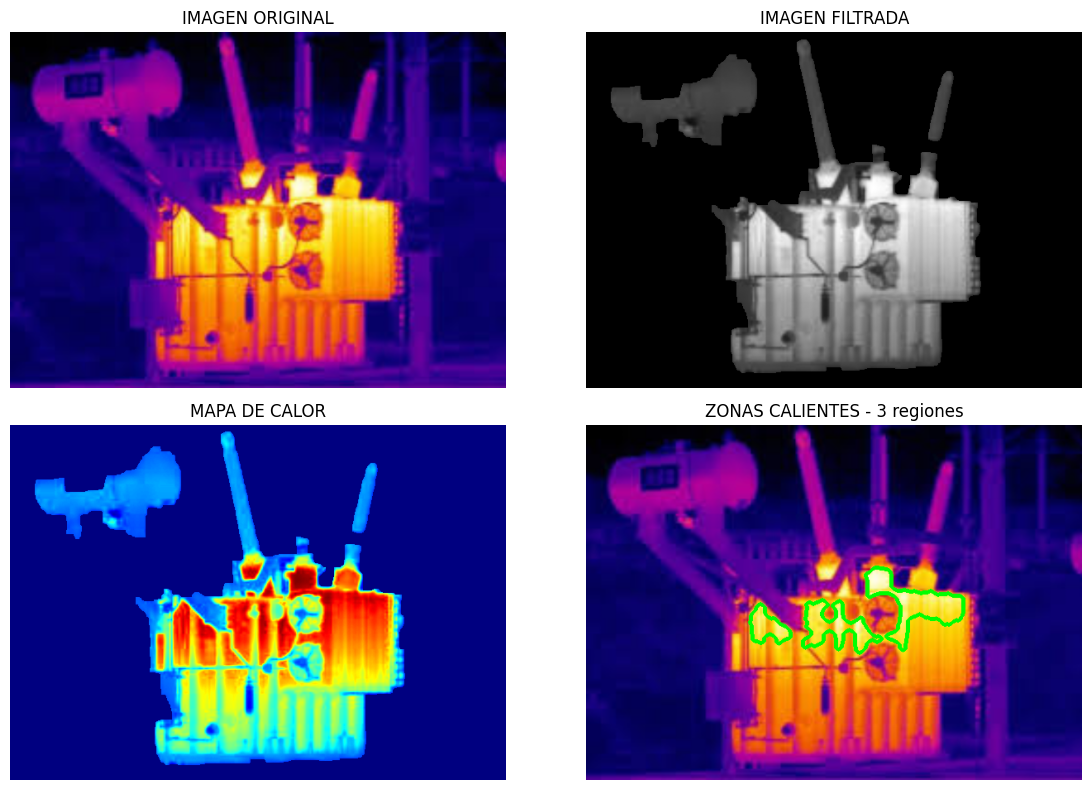


INFORMACIÓN TÉRMICA:
  Regiones calientes detectadas: 3
  - Región 1: centro=(397, 216), área=3912 px
  - Región 2: centro=(300, 244), área=2622 px
  - Región 3: centro=(218, 244), área=1277 px

OPINIÓN DEL MODELO:
   - Predicción: POSIBLE FALLA POR ANORMALIDAD TÉRMICA
   - Confianza: 100.00% (según datos actuales del modelo)

Por favor confirma la etiqueta real de la imagen:
1. Normal (no posibles fallos o anormalidades térmicas)
2. Posible Falla por Anormalidad Térmica (puntos calientes, sobrecalentamiento, etc.)
3. Cancelar (no guardar ni reentrenar)
Selecciona 1 (Normal), 2 (Posible Falla) o 3 (Cancelar): 2
Imagen guardada en: dataset_electrico/falla/user_Imagen_2.4_zones3.jpeg (color: ROJO)
Re-entrenando modelo con la nueva imagen (si hay datos suficientes)...

--- ENTRENANDO MODELO ---
Total de imágenes para entrenamiento: 371
Distribución de clases: Counter({np.int64(0): 196, np.int64(1): 175})
Precisión en test: 100.00%
Reporte de clasificación:
                               

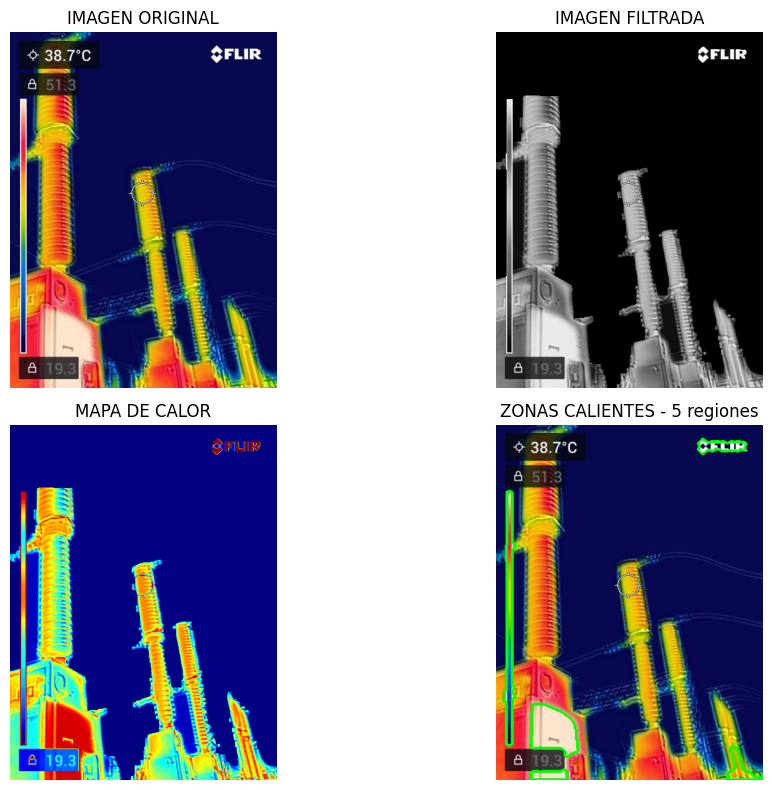


INFORMACIÓN TÉRMICA:
  Regiones calientes detectadas: 5
  - Región 1: centro=(95, 515), área=5052 px
  - Región 2: centro=(22, 333), área=4148 px
  - Región 3: centro=(378, 36), área=1211 px
  - Región 4: centro=(409, 581), área=1116 px
  - Región 5: centro=(89, 591), área=845 px

OPINIÓN DEL MODELO:
   - Predicción: POSIBLE FALLA POR ANORMALIDAD TÉRMICA
   - Confianza: 96.04% (según datos actuales del modelo)

Por favor confirma la etiqueta real de la imagen:
1. Normal (no posibles fallos o anormalidades térmicas)
2. Posible Falla por Anormalidad Térmica (puntos calientes, sobrecalentamiento, etc.)
3. Cancelar (no guardar ni reentrenar)
Selecciona 1 (Normal), 2 (Posible Falla) o 3 (Cancelar): 2
Imagen guardada en: dataset_electrico/falla/user_FLIR4486_zones5.jpg (color: ROJO)
Re-entrenando modelo con la nueva imagen (si hay datos suficientes)...

--- ENTRENANDO MODELO ---
Total de imágenes para entrenamiento: 372
Distribución de clases: Counter({np.int64(0): 196, np.int64(1): 176})
P

In [ ]:
def main():
    # Crear directorios si no existen
    for cat in CATEGORIAS:
        path = os.path.join(BASE_DIR, cat)
        os.makedirs(path, exist_ok=True)

    # Opción para descargar dataset
    print("¿Deseas descargar y preparar el dataset desde Kaggle (kagglehub)?")
    resp = input("s/n: ").strip().lower()
    if resp in ['s', 'si', 'sí', 'y', 'yes']:
        ok = descargar_y_preparar_dataset()
        if not ok:
            print("Continuando sin descargar dataset...")

    # Verificar datos existentes
    datos_ok, conteo = verificar_balance_datos()

    # Cargar o entrenar modelo
    modelo = None
    if os.path.exists(MODEL_FILE):
        try:
            modelo = joblib.load(MODEL_FILE)
            print("Modelo cargado correctamente")
        except Exception:
            print("ADVERTENCIA: Error cargando modelo existente")

    if modelo is None and datos_ok and min(conteo.values()) >= 2:
        modelo, _ = entrenar_modelo_simple()
    elif not datos_ok:
        print("\nSUGERENCIA: Añade imágenes a las carpetas 'normal' y 'falla' para entrenar el modelo")

    # Presentación del sistema
    print("\nSISTEMA DE ANÁLISIS TÉRMICO")
    print("   - El MAPA DE CALOR se mostrará; las zonas calientes se indican en VERDE en la vista separada")
    print(f"   - El modelo dará su opinión ({DISPLAY_LABELS['normal']}/{DISPLAY_LABELS['falla']}) con porcentaje, luego el usuario confirma")
    print("   - La imagen guardada será el MAPA DE CALOR con overlay verde (si confirmas)")

    # Bucle principal interactivo
    while True:
        try:
            modelo = analizar_imagen_interactivo(modelo)
            cont = input("\n¿Analizar otra imagen? (s/n): ").strip().lower()
            if cont not in ['s', 'si', 'sí', 'y', 'yes']:
                print("Programa finalizado.")
                break
        except KeyboardInterrupt:
            print("\n\nPrograma interrumpido por el usuario")
            break
        except Exception as e:
            print(f"\nERROR: Error inesperado: {e}")
            break
    plt.close('all')

if __name__ == "__main__":
    main()

## Programa Principal

La función `main()` es el punto de entrada del script y orquesta el flujo completo del sistema. Se encarga de la configuración inicial, la carga o el entrenamiento del modelo, y la ejecución del bucle interactivo para el análisis de imágenes.

### `main()`

- **Configuración Inicial de Directorios**: Asegura que las carpetas `normal` y `falla` existan dentro de `BASE_DIR`.
- **Descarga Opcional de Dataset**: Pregunta al usuario si desea descargar el dataset desde Kaggle y ejecuta la función `descargar_y_preparar_dataset()` si la respuesta es afirmativa.
- **Verificación y Carga de Datos**: Llama a `verificar_balance_datos()` para comprobar el estado del dataset local.
- **Carga o Entrenamiento del Modelo**:
    - Intenta cargar un modelo preexistente desde `MODEL_FILE`.
    - Si no hay un modelo o si la carga falla, y si hay suficientes datos, entrena un nuevo modelo llamando a `entrenar_modelo_simple()`.
    - Si no hay suficientes datos para entrenar, sugiere al usuario que añada más imágenes.
- **Mensaje de Bienvenida y Explicación**: Muestra un mensaje de bienvenida y explica brevemente cómo funciona el sistema interactivo.
- **Bucle Interactivo de Análisis**: Entra en un bucle `while True` que permite al usuario analizar mùltiples imágenes de forma consecutiva:
    - Llama a `analizar_imagen_interactivo()` para guiar al usuario a través del proceso de análisis de una imagen.
    - Pregunta al usuario si desea analizar otra imagen para continuar o salir del programa.
    - Incluye manejo de excepciones (`try-except`) para interrupciones del usuario (`KeyboardInterrupt`) y errores inesperados, asegurando una salida controlada.
- **Finalización**: Cierra todas las ventanas de Matplotlib abiertas al finalizar el programa.